In [1]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 19.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 12.6 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.31.0
    Uninstalling requests-2.31.0:
      Successfully uninstalled requests-2.31.0
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requir

In [2]:
from datasets import load_dataset, concatenate_datasets

dataset = load_dataset("mpingale/mental-health-chat-dataset")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/2775 [00:00<?, ? examples/s]

In [3]:
import torch
from transformers import MarianMTModel, MarianTokenizer

# Khởi tạo mô hình và tokenizer
model_name = 'Helsinki-NLP/opus-mt-en-vi'
model = MarianMTModel.from_pretrained(model_name).to('cuda')
tokenizer = MarianTokenizer.from_pretrained(model_name)

def translate_text(text):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512).to('cuda')
    translated = model.generate(**inputs)
    return tokenizer.decode(translated[0], skip_special_tokens=True)


config.json:   0%|          | 0.00/1.39k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/289M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/44.0 [00:00<?, ?B/s]

source.spm:   0%|          | 0.00/809k [00:00<?, ?B/s]

target.spm:   0%|          | 0.00/756k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.19M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/marian/tokenization_marian.py:175: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


In [4]:
dataset['train'].column_names

['questionID',
 'questionTitle',
 'questionText',
 'questionLink',
 'topic',
 'therapistInfo',
 'therapistURL',
 'answerText',
 'upvotes',
 'views',
 'text']

In [5]:
# Trích xuất và dịch các cột questionText, answerText
translated_data = {'questionText': [], 'answerText': []}
i = 0
for row in dataset["train"]:
    if i > 50:
        break
    else:
        question_text_vi = translate_text(row['questionText'])
        answer_text_vi = translate_text(row['answerText'])
        translated_data['questionText'].append(question_text_vi)
        translated_data['answerText'].append(answer_text_vi)
        i = i + 1

In [7]:
print(translated_data['questionText'][0])
print(translated_data['answerText'][0])

Tôi bị bệnh ung thư vú và mất ngủ cả đời. tôi có quá nhiều tiền sử trầm cảm và bắt đầu có vấn đề.
Nó là rất phổ biến cho người dân để có nhiều vấn đề mà họ muốn để (và cần phải) địa chỉ trong tư liệu. tôi đã có khách hàng yêu cầu cùng một câu hỏi và thông qua sự khám phá, có thường là một nỗi sợ tiềm ẩn rằng họ không thể được giúp đỡ" hoặc rằng họ sẽ "quá nhiều cho bác sĩ tâm lý của họ" tôi không biết nếu bất kỳ của vòng này đúng cho bạn. nhưng, hầu hết mọi người có nhiều hơn một vấn đề trong cuộc sống của họ và nhiều hơn nhiều hơn nữa, nhiều người có nhiều người có nhiều áp lực trong cuộc sống của họ. hoặc rằng họ sẽ phải đối mặt với cuộc sống, nó có thể được phức tạp! cuộc sống có thể được hoàn toàn sẵn sàng để xử lý các vấn đề lớn hoặc nhỏ trong một số vấn đề mà bạn sẽ giúp đỡ nhiều trong các vấn đề mà bạn có nhiều vấn đề mà bạn sẽ không bao giờ phải đối mặt trước tiên.


In [10]:
# Chuyển dữ liệu thành DataFrame và lưu thành file CSV
import pandas as pd

translated_df = pd.DataFrame(translated_data)
translated_df.to_csv('translated_mental_health_chat_dataset.csv', index=False)

#Bert eval

In [2]:
import pandas as pd

translated_df = pd.read_csv('translated_mental_health_chat_dataset.csv')


In [12]:
!pip install -q -U bitsandbytes
!pip install -q -U datasets
!pip install -q -U git+https://github.com/huggingface/transformers.git
!pip install -q -U git+https://github.com/huggingface/peft.git
!pip install -q -U git+https://github.com/huggingface/accelerate.git
!pip install -q -U loralib
!pip install -q -U einops
!pip install hugchat==0.0.8

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.5/137.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 18.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 4.2 MB/s eta 0:00:00


In [3]:
import json
import os
import bitsandbytes as bnb
import torch
import torch.nn as nn
import transformers

from pprint import pprint
from tqdm import tqdm
from datasets import load_dataset, Dataset
from huggingface_hub import notebook_login
from peft import (
    LoraConfig,
    PeftConfig,
    PeftModel,
    get_peft_model,
    prepare_model_for_kbit_training
)
from transformers import (
    AutoConfig,
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig
)

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [4]:
PEFT_MODEL = "thailevann/vinallama-mental-health"

config = PeftConfig.from_pretrained(PEFT_MODEL)
if not config.base_model_name_or_path:
    config.base_model_name_or_path = "vilm/vinallama-7b-chat"
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

model = AutoModelForCausalLM.from_pretrained(
    config.base_model_name_or_path,
    return_dict=True,
    quantization_config=bnb_config,
    device_map="auto",
    trust_remote_code=True
)

tokenizer=AutoTokenizer.from_pretrained(config.base_model_name_or_path)
tokenizer.pad_token = tokenizer.eos_token

model = PeftModel.from_pretrained(model, PEFT_MODEL)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/3.80G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/314 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.74k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.67M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/557 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/160M [00:00<?, ?B/s]

In [5]:

generation_config = model.generation_config
generation_config.max_new_tokens = 512
generation_config.temperature = 0.7
generation_config.top_p = 0.7
generation_config.num_return_sequences = 1
generation_config.pad_token_id = model.config.pad_token_id
generation_config.eos_token_id = model.config.eos_token_id
generation_config.no_repeat_ngram_size=3

generation_config.do_sample = True       # Sử dụng sampling

In [6]:
import re

def is_complete(text):
    # Kiểm tra xem văn bản có kết thúc bằng dấu chấm, dấu chấm than, hoặc ký tự xuống dòng không
    return re.search(r'(\.|!|\?)$', text) is not None

def get_complete_text(text):
    # Cắt văn bản dư thừa sau dấu chấm, dấu chấm than, hoặc ký tự xuống dòng cuối cùng
    match = re.search(r'(\.|!|\?)\s*$', text)
    if match:
        end_pos = match.end()
        return text[:end_pos]
    return text

def process_response(response):
    # Kiểm tra và cắt văn bản sinh ra
    if not is_complete(response):
        response = get_complete_text(response)
    return response


In [ ]:

%%time
device = 'cuda' if torch.cuda.is_available() else 'cpu'

prompt = """
<|im_start|>system
Bạn là một chuyên gia về tham vấn sức khỏe tâm thần. Bạn sẽ nhận câu hỏi của người bệnh, hãy trả lời hoặc đưa ra lời khuyên dành cho họ.

<|im_start|>user
### Câu hỏi:
Tôi đang trải qua một số điều với cảm xúc của tôi và bản thân mình. Tôi hầu như không ngủ và không làm gì ngoài việc nghĩ về việc mình thật vô dụng và lẽ ra mình không nên ở đây. Tôi chưa bao giờ thử hoặc có ý định tự tử. Tôi luôn muốn giải quyết vấn đề của mình nhưng chưa bao giờ thực hiện được. Làm thế nào tôi có thể thay đổi cảm giác mình vô dụng đối với mọi người?
### Câu trả lời:

<|im_start|>assistant
""".strip()

encoding = tokenizer(prompt, return_tensors="pt").to(device)
with torch.inference_mode():
    outputs = model.generate(
        input_ids=encoding.input_ids,
        attention_mask=encoding.attention_mask,
        generation_config=generation_config
    )
response = tokenizer.decode(outputs[0], skip_special_tokens=True)
complete_response = process_response(response)

print(complete_response)

In [8]:
pip install bert_score

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 3.8 MB/s eta 0:00:00


In [13]:
pip install sacrebleu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.0/58.0 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 6.7 MB/s eta 0:00:00


In [15]:
pip install rouge_score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=9156c0204544e62720f31718bc58b301eecd443001cca6f32d404b11cb0f005e
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge_score


In [18]:
pip install nltk

In [20]:
%%time

from bert_score import score as bert_score
import sacrebleu
from rouge_score import rouge_scorer
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
# Khởi tạo phân tích cảm xúc và chủ quan
nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()
def sentiment_analysis(text):
    return sia.polarity_scores(text)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
results = []
for i, row in translated_df.iterrows():
    question_text_vi = row['questionText']
    answer_text_vi = row['answerText']
    prompt = f"""
    <|im_start|>system
    Bạn là một chuyên gia về tham vấn sức khỏe tâm thần. Bạn sẽ nhận câu hỏi của người bệnh, hãy trả lời hoặc đưa ra lời khuyên dành cho họ.

    <|im_start|>user
    ### Câu hỏi:
    {question_text_vi}
    ### Câu trả lời:

    <|im_start|>assistant
    """.strip()


    encoding = tokenizer(prompt, return_tensors="pt").to(device)
    with torch.inference_mode():
        outputs = model.generate(
            input_ids=encoding.input_ids,
            attention_mask=encoding.attention_mask,
            generation_config=generation_config
        )
    response = tokenizer.decode(outputs[0], skip_special_tokens=True)
    complete_response = process_response(response)
    complete_response =  complete_response.split("<|im_start|> assistant")[-1]
    predicted_sentiment = sentiment_analysis(complete_response)
    actual_sentiment = sentiment_analysis(answer_text_vi)
    # Tính BERTScore
    P, R, F1 = bert_score([complete_response], [answer_text_vi], lang="vi", rescale_with_baseline=True)

    # Tính BLEU score
    bleu = sacrebleu.corpus_bleu([complete_response], [[answer_text_vi]]).score

    # Tính ROUGE score
    rouge_scorer_inst = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    rouge_scores = rouge_scorer_inst.score(complete_response, answer_text_vi)

    # Lưu kết quả
    result = {
        'questionText': question_text_vi,
        'predictedAnswer': complete_response,
        'actualAnswer': answer_text_vi,
        'bert_score': {
            'precision': P.item(),
            'recall': R.item(),
            'f1': F1.item()
        },
        'bleu_score': bleu,
        'rouge_score': {
            'rouge1': rouge_scores['rouge1'].fmeasure,
            'rouge2': rouge_scores['rouge2'].fmeasure,
            'rougeL': rouge_scores['rougeL'].fmeasure
        },
        'predictedSentiment': predicted_sentiment,
        'actualSentiment': actual_sentiment
    }
    results.append(result)

# Lưu kết quả vào file JSON
with open('bert_score_results.json', 'w', encoding='utf-8') as f:
    json.dump(results, f, ensure_ascii=False, indent=4)

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter n

CPU times: user 31min 10s, sys: 26.6 s, total: 31min 37s
Wall time: 32min 1s


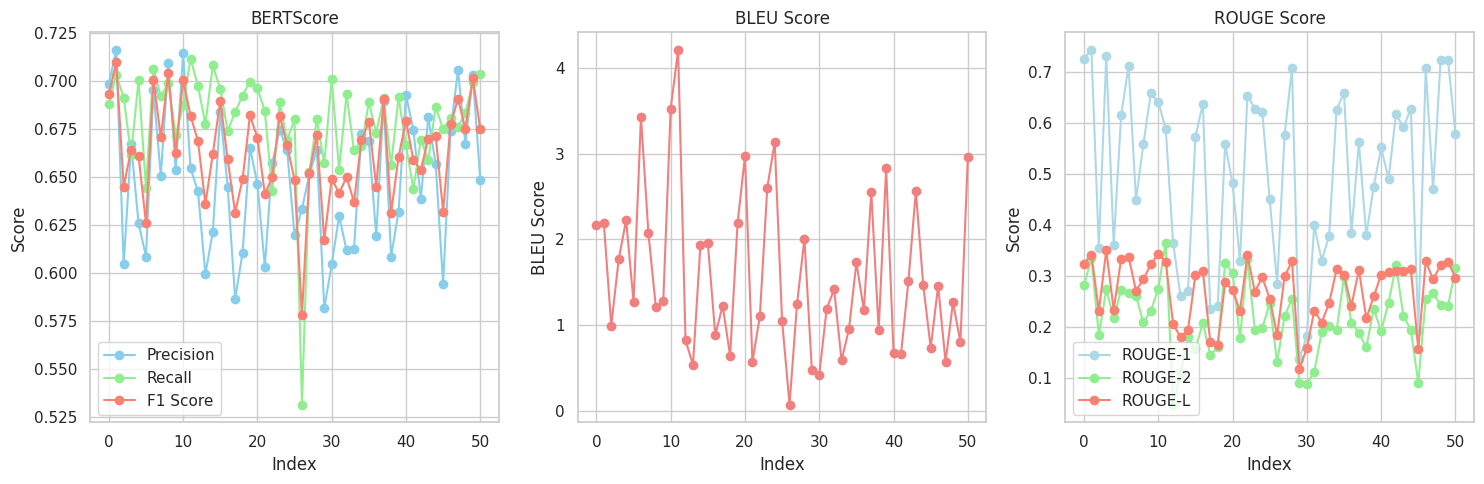

<Figure size 1000x600 with 0 Axes>

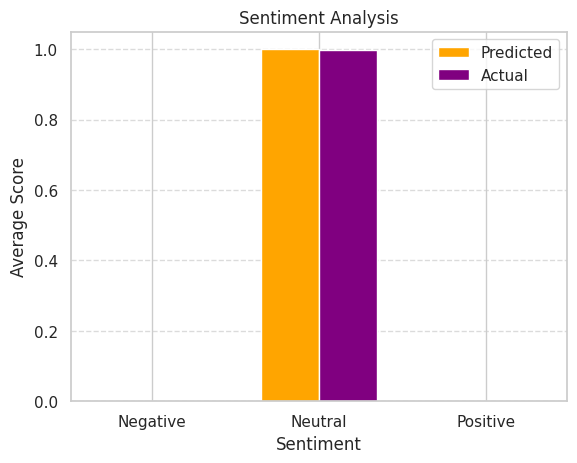

In [24]:
import json
import matplotlib.pyplot as plt

# Đọc dữ liệu từ tệp JSON
with open('bert_score_results.json', 'r', encoding='utf-8') as f:
    data = json.load(f)

# Khởi tạo các danh sách để lưu trữ các giá trị cho từng chỉ số
precision = []
recall = []
f1 = []
bleu_scores = []
rouge1 = []
rouge2 = []
rougeL = []
predicted_sentiments = {'neg': [], 'neu': [], 'pos': []}
actual_sentiments = {'neg': [], 'neu': [], 'pos': []}

# Duyệt qua từng đối tượng trong danh sách
for item in data:
    bert_scores = item["bert_score"]
    precision.append(bert_scores["precision"])
    recall.append(bert_scores["recall"])
    f1.append(bert_scores["f1"])

    bleu_scores.append(item["bleu_score"])

    rouge_scores = item["rouge_score"]
    rouge1.append(rouge_scores["rouge1"])
    rouge2.append(rouge_scores["rouge2"])
    rougeL.append(rouge_scores["rougeL"])

    predicted_sentiments['neg'].append(item["predictedSentiment"]["neg"])
    predicted_sentiments['neu'].append(item["predictedSentiment"]["neu"])
    predicted_sentiments['pos'].append(item["predictedSentiment"]["pos"])

    actual_sentiments['neg'].append(item["actualSentiment"]["neg"])
    actual_sentiments['neu'].append(item["actualSentiment"]["neu"])
    actual_sentiments['pos'].append(item["actualSentiment"]["pos"])

# Vẽ sơ đồ đường cho BERTScore
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.plot(range(len(precision)), precision, marker='o', label='Precision', color='skyblue')
plt.plot(range(len(recall)), recall, marker='o', label='Recall', color='lightgreen')
plt.plot(range(len(f1)), f1, marker='o', label='F1 Score', color='salmon')
plt.xlabel('Index')
plt.ylabel('Score')
plt.title('BERTScore')
plt.legend()
plt.grid(True)

# Vẽ sơ đồ đường cho BLEU Score
plt.subplot(1, 3, 2)
plt.plot(range(len(bleu_scores)), bleu_scores, marker='o', color='lightcoral')
plt.xlabel('Index')
plt.ylabel('BLEU Score')
plt.title('BLEU Score')
plt.grid(True)

# Vẽ sơ đồ đường cho ROUGE Score
plt.subplot(1, 3, 3)
plt.plot(range(len(rouge1)), rouge1, marker='o', label='ROUGE-1', color='lightblue')
plt.plot(range(len(rouge2)), rouge2, marker='o', label='ROUGE-2', color='lightgreen')
plt.plot(range(len(rougeL)), rougeL, marker='o', label='ROUGE-L', color='salmon')
plt.xlabel('Index')
plt.ylabel('Score')
plt.title('ROUGE Score')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('score_trends.png')
plt.show()

# Vẽ biểu đồ cột cho phân tích cảm xúc
sentiments = ['Negative', 'Neutral', 'Positive']

# Tính toán giá trị trung bình cho các cảm xúc dự đoán và thực tế
predicted_values = {
    'Negative': sum(predicted_sentiments['neg']) / len(predicted_sentiments['neg']),
    'Neutral': sum(predicted_sentiments['neu']) / len(predicted_sentiments['neu']),
    'Positive': sum(predicted_sentiments['pos']) / len(predicted_sentiments['pos'])
}

actual_values = {
    'Negative': sum(actual_sentiments['neg']) / len(actual_sentiments['neg']),
    'Neutral': sum(actual_sentiments['neu']) / len(actual_sentiments['neu']),
    'Positive': sum(actual_sentiments['pos']) / len(actual_sentiments['pos'])
}

x = range(len(sentiments))
width = 0.35

plt.figure(figsize=(10, 6))
fig, ax = plt.subplots()
bars1 = ax.bar(x, list(predicted_values.values()), width, label='Predicted', color='orange')
bars2 = ax.bar([p + width for p in x], list(actual_values.values()), width, label='Actual', color='purple')

ax.set_xlabel('Sentiment')
ax.set_ylabel('Average Score')
ax.set_title('Sentiment Analysis')
ax.set_xticks([p + width / 2 for p in x])
ax.set_xticklabels(sentiments)
ax.legend()

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.savefig('sentiment_analysis.png')
plt.show()
